In [76]:
import openaq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aqtools import aqutils as u
api = openaq.OpenAQ()

In [82]:
status, resp = api.measurements(city = 'San Francisco-Oakland-Fremont', location='Oakland', parameter=['pm25','co', 'no2','o3'], limit=7000)
r = resp['results']
df = pd.DataFrame(data=r)

dates = []
for date in df['date'].values:
    local_date = date['local']
    d = u.cleaning_date(local_date)
    dates.append(d)
df['date'] = dates
df = df.reindex(columns=['parameter', 'value', 'date'])
df = df.pivot(index='date', columns='parameter', values='value')
df = df.dropna()
df

parameter,co,no2,o3,pm25
date,,,,
2021-11-22 22:00:00,0.64,0.019,0.002,18.0
2021-11-22 23:00:00,0.49,0.014,0.004,22.0
2021-11-23 00:00:00,0.38,0.011,0.005,22.0
2021-11-23 01:00:00,0.40,0.011,0.004,12.0
2021-11-23 02:00:00,0.45,0.012,0.002,20.0
...,...,...,...,...
2022-05-10 02:00:00,0.24,0.004,0.033,5.0
2022-05-10 03:00:00,0.31,0.009,0.018,2.0
2022-05-10 05:00:00,0.37,0.013,0.013,5.0


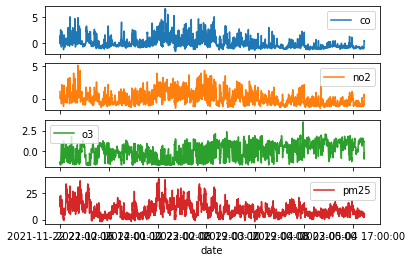

In [83]:
# Standardization
co = df['co'].values
co_standardized = (co - co.mean()) / co.std()
df['co'] = co_standardized

no2 = df['no2'].values
no2_standardized = (no2 - no2.mean()) / no2.std()
df['no2'] = no2_standardized

o3 = df['o3'].values
o3_standardized = (o3 - o3.mean()) / o3.std()
df['o3'] = o3_standardized
df.plot(subplots=True)
plt.show()


/tmp/ipykernel_8105/1345606581.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co'] = co_diff
/tmp/ipykernel_8105/1345606581.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no2'] = no2_diff
/tmp/ipykernel_8105/1345606581.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

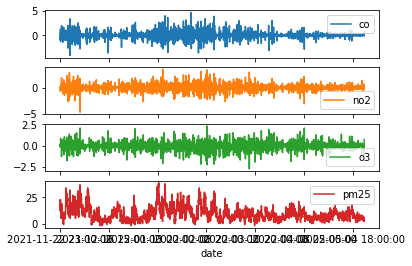

In [84]:
# Make data stationary
co_diff = u.differencing(df['co'].values)
no2_diff = u.differencing(df['no2'].values)
o3_diff = u.differencing(df['o3'].values)

# Delete the first row
df = df.iloc[1:, :]

df['co'] = co_diff
df['no2'] = no2_diff
df['o3'] = o3_diff
df.plot(subplots=True)
plt.show()

In [148]:
# feature vectors
feature_np = df.to_numpy()[:, :3]
print(feature_np)
# label
label_np = df.to_numpy()[:, -1]
X = []
y = []
for i in range(24, len(feature_np)):
    X.append(feature_np[i-24:i, :])
    y.append(label_np[i])

X, y = np.array(X), np.array(y)
X.shape, y.shape

[[-0.83807032 -0.67027141  0.1605349 ]
 [-0.6145849  -0.40216285  0.08026745]
 [ 0.11174271  0.         -0.08026745]
 ...
 [ 0.33522813  0.53621713 -0.40133725]
 [ 0.67045625  0.40216285 -0.3210698 ]
 [-0.11174271 -0.40216285  0.72240704]]


((3094, 24, 3), (3094,))

In [150]:
TEST_SIZE = 300

X_train = X[:-TEST_SIZE]
y_train = y[:-TEST_SIZE]
X_test = X[-TEST_SIZE:]
y_test = y[-TEST_SIZE:]


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2794, 24, 3), (2794,), (300, 24, 3), (300,))

In [151]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(GRU(units=50, activation="tanh", return_sequences=True, input_shape = X_train[0].shape))
model.add(Dropout(0.2))
model.add(GRU(units=50, activation="tanh", return_sequences=True, input_shape = X_train[0].shape))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_25 (GRU)                (None, 24, 50)            8250      
                                                                 
 dropout_21 (Dropout)        (None, 24, 50)            0         
                                                                 
 gru_26 (GRU)                (None, 24, 50)            15300     
                                                                 
 dropout_22 (Dropout)        (None, 24, 50)            0         
                                                                 
 dense_11 (Dense)            (None, 24, 1)             51        
                                                                 
Total params: 23,601
Trainable params: 23,601
Non-trainable params: 0
_________________________________________________________________


In [152]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='mse', optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False))
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=50, callbacks=[early_stop])

Epoch 1/100
56/56 [==============================] - 8s 58ms/step - loss: 49.6502 - val_loss: 10.3565
Epoch 2/100
56/56 [==============================] - 2s 44ms/step - loss: 46.0245 - val_loss: 20.0075
Epoch 3/100
56/56 [==============================] - 2s 43ms/step - loss: 44.3548 - val_loss: 17.1156
Epoch 4/100
56/56 [==============================] - 2s 41ms/step - loss: 43.3112 - val_loss: 16.4533
Epoch 5/100
56/56 [==============================] - 2s 40ms/step - loss: 43.5749 - val_loss: 15.8100
Epoch 6/100
56/56 [==============================] - 2s 42ms/step - loss: 43.8366 - val_loss: 9.8520
Epoch 7/100
56/56 [==============================] - 2s 42ms/step - loss: 43.9482 - val_loss: 22.2574
Epoch 8/100
56/56 [==============================] - 2s 41ms/step - loss: 43.4037 - val_loss: 11.9461
Epoch 9/100
56/56 [==============================] - 2s 41ms/step - loss: 43.2254 - val_loss: 17.3520
Epoch 10/100
56/56 [==============================] - 2s 41ms/step - loss: 43.6472 

In [132]:
# pred = model.predict(X_test)
# print(pred.shape)
# plt.figure(figsize=(12,6))
# plt.plot(y_test, label='actual')
# plt.plot(pred, label='prediction')
# plt.grid()
# plt.legend(loc='best')
# plt.show()
mse,mae = model.evaluate(X_test,y_test,batch_size=50)

7/7 [==============================] - 1s 5ms/step - loss: 12.7942


TypeError: cannot unpack non-iterable float object